# Benchmark 2: Four-Layered Inversely-Dispersive System

## License Information
---

This file is distributed as part of _swprocess_, a Python package for surface wave processing.

    Copyright (C) 2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.

## About _swprocess_ and this notebook
---

_swprocess_ is a Python package for surface wave processing. _swprocess_ was developed by
Joseph P. Vantassel under the supervision of Professor Brady R. Cox at The University of
Texas at Austin.

If you use _swprocess_ in your research or consulting, we ask you please cite the following:

> Vantassel, J. P. (2021). jpvantassel/swprocess: latest (Concept). Zenodo.
> [https://doi.org/10.5281/zenodo.4584128](https://doi.org/10.5281/zenodo.4584128)

> Vantassel, J. P. & Cox, B. R. (2021). "SWprocess: A workflow for developing robust
> estimates of surface wave dispersion uncertainty". Submitted to a special edition of the
> Journal of Seismology organized by the Consortium of Organizations for Strong Motion
> Observation Systems (COSMOS)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for swprocess, please use the citation tool on the swprocess
[archive](https://doi.org/10.5281/zenodo.4584128)._

This notebooks compares active-source surface wave dispersion data
computed from waveforms simulated using the dynamic finite element
software LS-DYNA with the theoretical surface wave dispersion modes determined
using the Thomson (1950) - Haskell (1953) Transfer Matrix
solution as implemented by Wathelet (2005).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import swprepost
import swprocess
import sigpropy

## The Model

To simulate the waveforms we must define an experimental model. The details of this model are provided below.

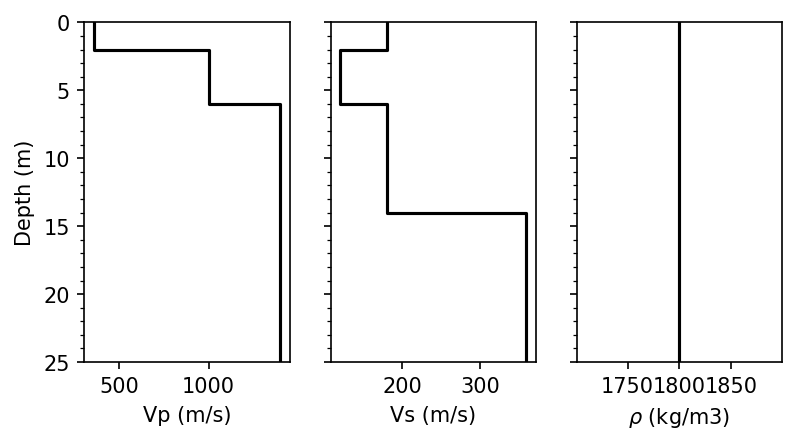

In [2]:
tk = [2, 4, 8, 0]
vp = [360, 1000, 1400, 1400]
vs = [180, 120, 180, 360]
rh = [1800]*4
gm = swprepost.GroundModel(thickness=tk, vp=vp, vs=vs, density=rh)

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(6,3), dpi=150)

for ax, par, xlabel in zip(axs, [gm.vp2, gm.vs2, gm.rh2], ["Vp (m/s)", "Vs (m/s)", r"$\rho$"+" (kg/m3)"]):
    ax.plot(par, gm.depth, color="#000000")
    ax.set_xlabel(xlabel)

ax = axs[0]
ax.set_ylabel("Depth (m)")
ax.set_ylim((25,0))
ax.set_yticks(np.arange(0, 25, 1), minor=True)

plt.show()

## Wavelet

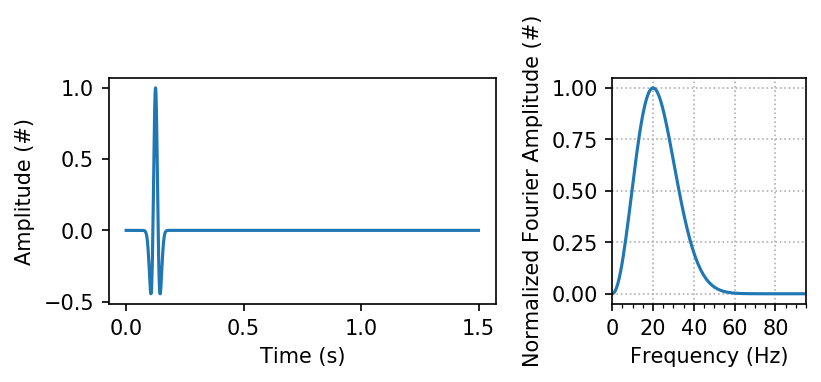

In [3]:
df = pd.read_csv("ricker_fc20hz.csv")
time = df["Time (s)"]
amplitude = df["Amplitude (#)"]
dt = time[1] - time[0]

tseries = sigpropy.TimeSeries(amplitude=amplitude, dt=dt)
fseries = sigpropy.FourierTransform.from_timeseries(tseries)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,2), dpi=150, gridspec_kw=dict(wspace=0.4, width_ratios=[1,0.5]))

ax = axs[0]
ax.plot(tseries.time, tseries.amplitude)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (#)")

ax = axs[1]
ax.plot(fseries.frq, fseries.mag/np.max(fseries.mag))
ax.set_xlim(0, 80)
ax.set_xticks(np.arange(0,100,20))
ax.set_xticks(np.arange(0,100,5), minor=True)
ax.grid(linestyle=":")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Normalized Fourier Amplitude (#)")

plt.show()

## Thomson-Haskell

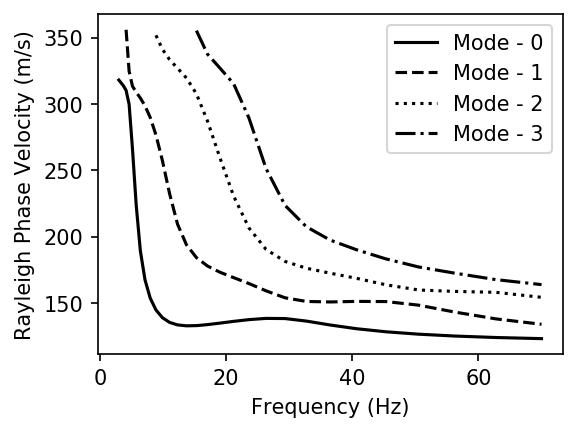

In [4]:
# dc_set = gm.calc_dc(gpdc_kwargs={"-R":4, "-min":3, "-max":70, "-n":30})
dc_set = swprepost.DispersionSet.from_geopsy("mod2_dc.txt")

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

for (model, dc), linestyle in zip(dc_set.rayleigh.items(), ["-", "--", ":", "-."]):
    ax.plot(dc.frequency, dc.velocity, label=f"Mode - {model}", color="#000000", linestyle=linestyle)
ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
ax.set_xlabel("Frequency (Hz)")
ax.legend()
plt.show()

## Compare Simulated and Thomson-Haskell

Analysis of -> 46m_2m_-5m.su


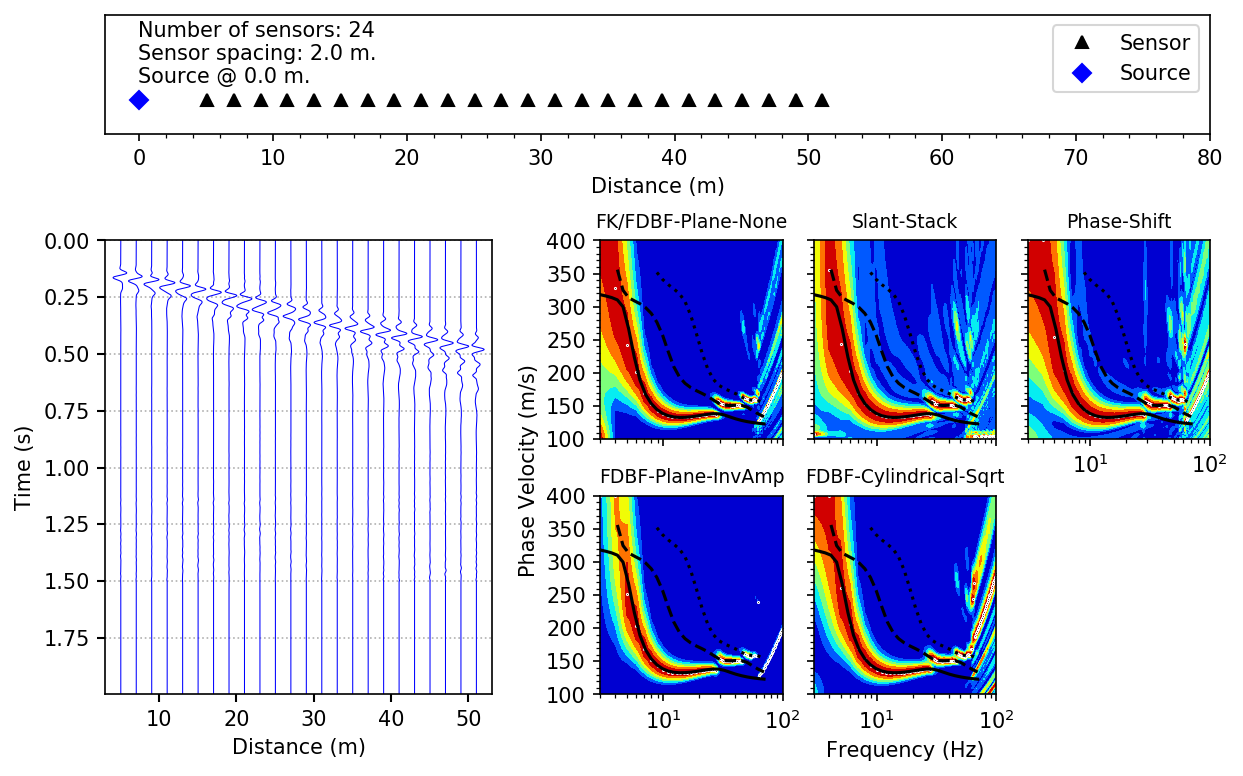





Analysis of -> 46m_2m_-10m.su


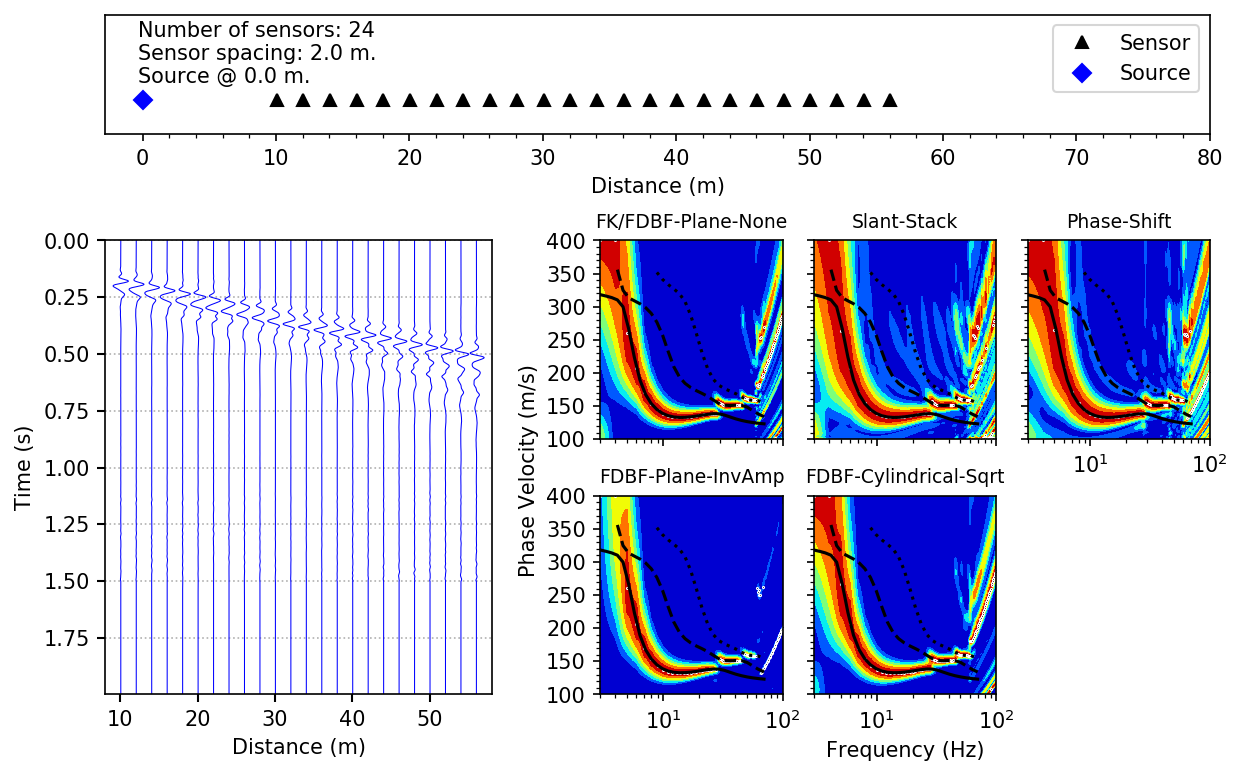





Analysis of -> 46m_2m_-20m.su


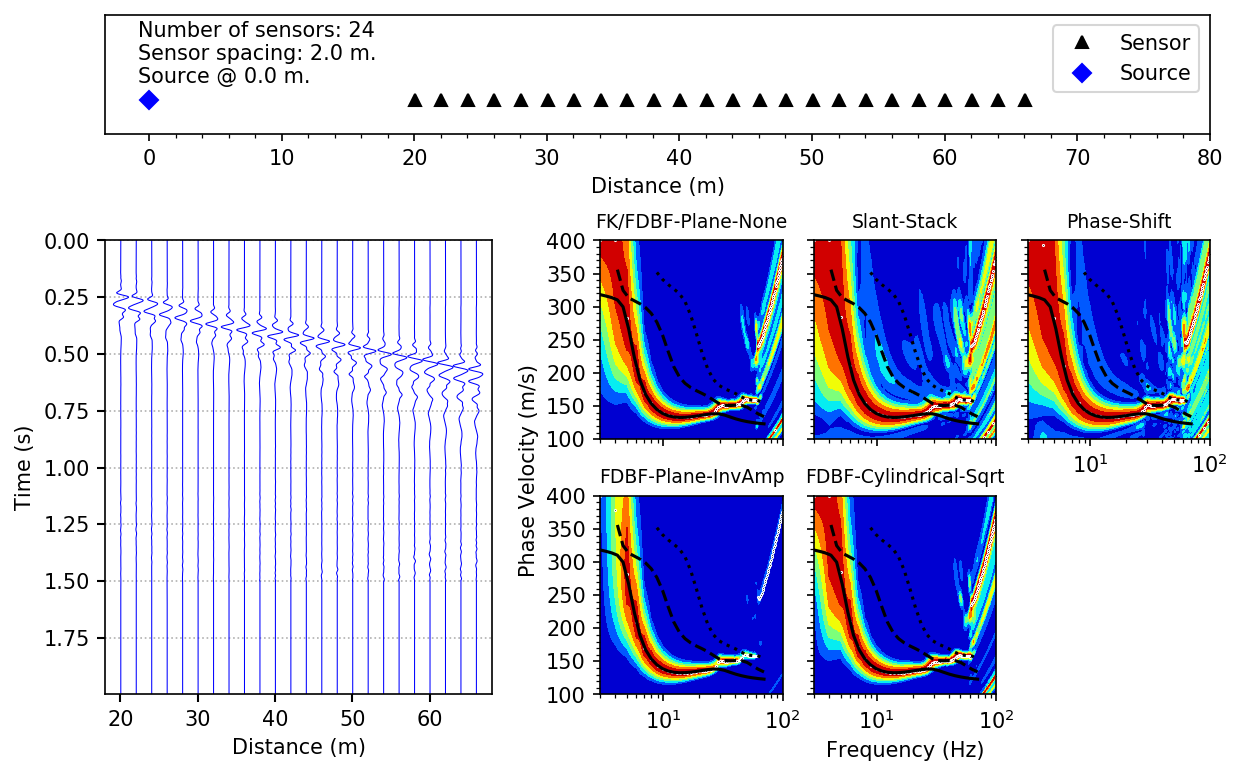





Analysis of -> 60m_Xm_-5m.su


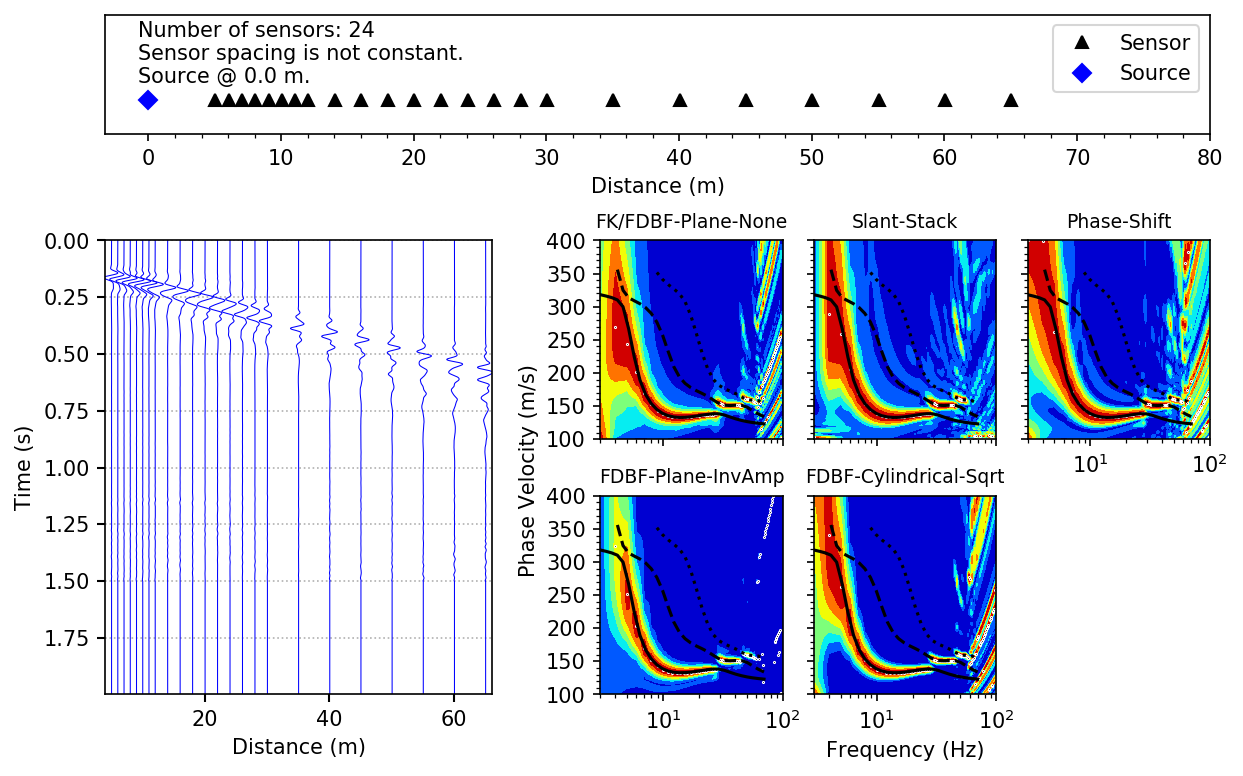





Analysis of -> 60m_Xm_-10m.su


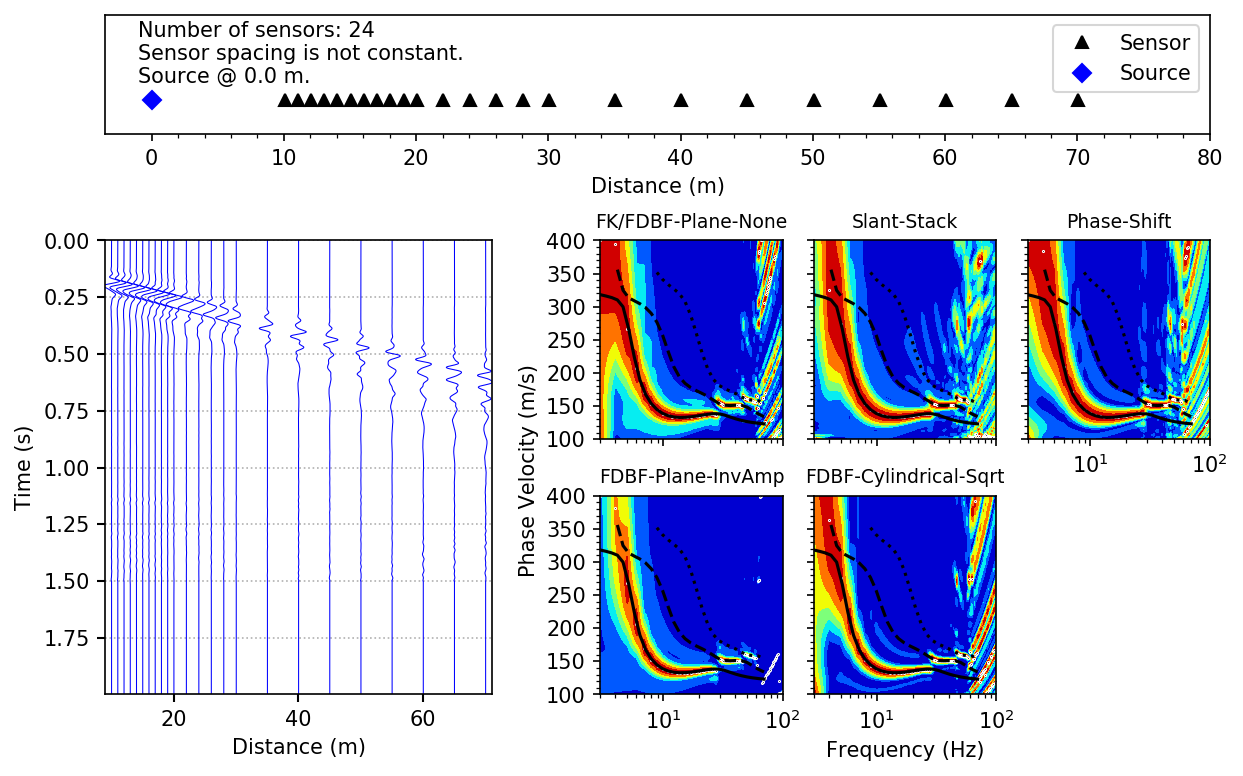

In [5]:
fnames = ["46m_2m_-5m.su",
          "46m_2m_-10m.su",
          "46m_2m_-20m.su",
          "60m_Xm_-5m.su",
          "60m_Xm_-10m.su"]

vmin, vmax = 100, 400
fmin, fmax = 3, 100
for fname in fnames:
    print(f"Analysis of -> {fname}")
    fig = plt.figure(figsize=(9.5, 6), dpi=150)
    gs = mpl.gridspec.GridSpec(nrows=5, ncols=6, figure=fig, height_ratios=[0.6,0.25,1,0.0,1], hspace=0.25, width_ratios=[1,0.95,0.25,1,1,1])
    ax0 = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[2:, :2])
    ax2 = fig.add_subplot(gs[2, 3])
    ax3 = fig.add_subplot(gs[2, 4])
    ax4 = fig.add_subplot(gs[2, 5])
    ax5 = fig.add_subplot(gs[4, 3])
    ax6 = fig.add_subplot(gs[4, 4])
#     ax7 = fig.add_axes(gs[4, 5])
    
    axs = [ax2, ax3, ax4, ax5, ax6]
    labels = ["FK/FDBF-Plane-None", "Slant-Stack", "Phase-Shift", "FDBF-Plane-InvAmp", "FDBF-Cylindrical-Sqrt"]
    for ax, label, transform, normalization, weighting, steering in zip(axs, labels,
                                                  ["fk", "slantstack", "phaseshift", "fdbf", "fdbf"],
                                                  ["frequency-maximum", "frequency-maximum", "frequency-maximum", "absolute-maximum", "frequency-maximum"],
                                                  ["n/a", "n/a", "n/a", "invamp", "sqrt"],
                                                  ["n/a", "n/a", "n/a", "plane", "cylindrical"]):
        
        settings = swprocess.Masw.create_settings_dict(transform=transform, weighting=weighting, steering=steering,
                                                       vmin=vmin, vmax=vmax, fmin=fmin, fmax=fmax, pad=True, df=1)
        result = swprocess.Masw.run(fnames=fname, settings=settings)
        result.normalize(normalization)
        ax.contourf(result.frequencies, result.velocities, result.power, cmap="jet")
        ax.plot(result.frequencies, result.find_peak_power(),
                marker="o", markersize=0.5, markerfacecolor="#000000", markeredgecolor="#ffffff", linestyle="")
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        
        ax.set_xscale("log")
        for (model, dc), linestyle in zip(dc_set.rayleigh.items(), ["-", "--", ":"]):
            ax.plot(dc.frequency, dc.velocity, label=f"Mode - {model}", color="#000000", linestyle=linestyle)

        ax.set_xticks([10,100])
        ax.set_xticks([3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100], minor=True)
        
        ax.set_yticks(np.arange(vmin, vmax+50, 50))
        ax.set_yticks(np.arange(vmin, vmax+10, 10), minor=True)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        
        ax.set_title(label, fontsize=9)
    
    for ax in [ax3, ax4, ax6]:
        ax.set_yticklabels("")

    for ax in [ax2, ax3]:
        ax.set_xticklabels("")

    ax6.set_xlabel("Frequency (Hz)")
    fig.text(0.415, 0.26, "Phase Velocity (m/s)", rotation=90)
    
    # Array
    result.array.plot(ax=ax0)
    ax0.set_yticks([])
    ax0.set_xticks(np.arange(0, 90, 10))
    ax0.set_xticks(np.arange(0, 80, 2), minor=True)
    
    # Waterfall
    result.array.waterfall(ax=ax1)

    plt.show()
    print("\n\n\n")